In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
path_list = os.listdir(r"../data")
path_list = sorted(path_list, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
path_list

['1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg',
 '11.png']

In [3]:
imgs = []
for path in path_list:
    # target img
    path = os.path.join(r"../data", path)
    img = cv.imread(path)
    imgs.append(img)

In [4]:
backgrounds = imgs[:5]
foregrounds = imgs[5:]

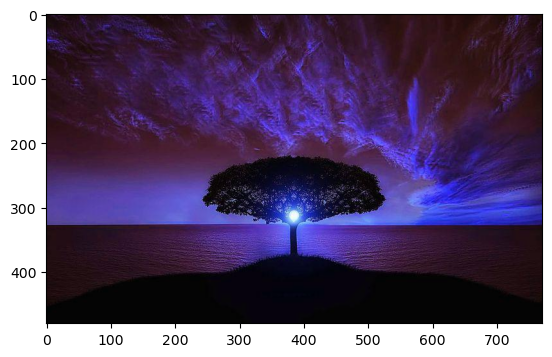

In [5]:
img = imgs[0]
plt.imshow(img)

In [6]:
# gaussian pyramid function
def gaussian(img, number):
    imgs = [img]
    for i in range(number):
        img = cv.pyrDown(img)
        imgs.append(img)
    return imgs

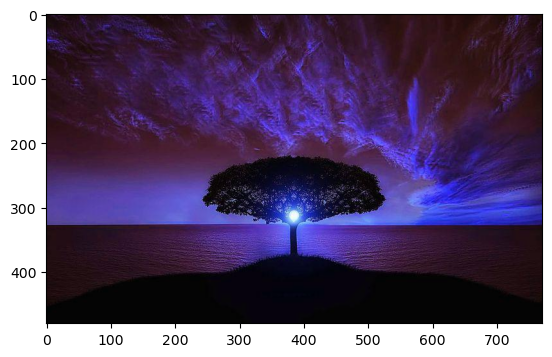

In [7]:
plt.imshow(gaussian(img, 5)[0])

In [8]:
def laplacian(gauss_imgs, number):
    imgs = [gauss_imgs[-1]]
    for i in range(number - 1, -1, -1):
        height, width, d = gauss_imgs[i].shape
        size = width, height
        expanded_gauss = cv.pyrUp(gauss_imgs[i + 1], dstsize=size)
        laplace = cv.subtract(gauss_imgs[i], expanded_gauss)
        imgs.append(laplace)
    return imgs

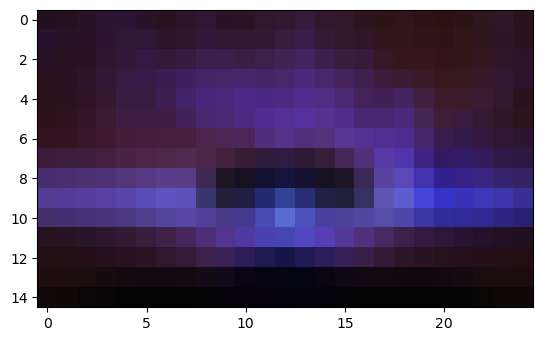

In [9]:
plt.imshow(laplacian(gaussian(img, 5), 5)[0])

In [10]:
# masking function using otsu method
def mask(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    T, threshold = cv.threshold(gray, np.median(gray), 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    thresh_with_blur = cv.medianBlur(threshold, 15, 0)
    return thresh_with_blur

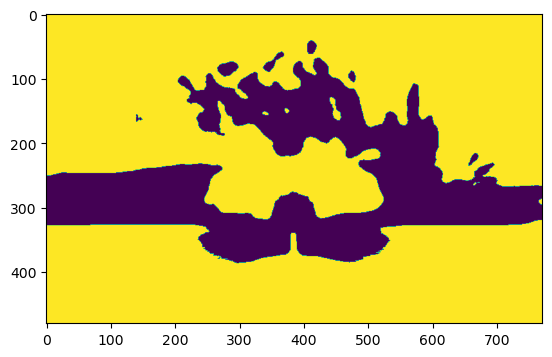

In [11]:
plt.imshow(mask(img))

In [12]:
# blending function
def blend(imgs1, imgs2, masks):
    blendeds = []
    for (la, lb, lmsk) in zip(imgs1, imgs2, masks):
        ratio = np.count_nonzero(lmsk) / (lmsk.shape[0] * lmsk.shape[1])
        if np.mean((1 - lmsk) * lb) / (1 - ratio) < np.mean(lmsk * lb) / ratio:
            blended = (1 - lmsk) * lb + lmsk * la
        else:
            blended = lmsk * lb + (1 - lmsk) * la
        blendeds.append(blended)
    return blendeds

In [13]:
# reconstructing function
def reconstruct(imgs):
    top = imgs[0]
    lst = [top]
    number = len(imgs) - 1
    for i in range(number):
        height, width, d = imgs[i + 1].shape
        size = width, height
        lap_expanded = cv.pyrUp(top, dstsize=size)
        top = cv.add(imgs[i + 1], lap_expanded)
        lst.append(top)
    return lst

In [14]:

# levels
for level in range(1,11):
    # creating a filepath for different levels
    if not os.path.isdir(f"./result/{level}"):
        os.mkdir(f"./result/{level}")
    # background images
    for i, img1 in enumerate(backgrounds):
        # foreground images
        for j, img2 in enumerate(foregrounds):
            # height and width to resize
            height, width, d = img1.shape
            img2 = cv.resize(img2, (width, height))
            # gaussian images
            gauss_imgs1 = gaussian(img1, level)
            gauss_imgs2 = gaussian(img2, level)
            # laplacian images
            laplacian_imgs1 = laplacian(gauss_imgs1, level)
            laplacian_imgs2 = laplacian(gauss_imgs2, level)
            # mask
            mask_img = mask(img2)
            mask_img = np.clip(mask_img, a_min=0, a_max=1)
            mask_img = cv.cvtColor(mask_img, cv.COLOR_GRAY2RGB)
            # gaussian masks
            gauss_masks = gaussian(mask_img, level)
            gauss_masks.reverse()
            # blending and reconstructing
            add_laplace = blend(laplacian_imgs1, laplacian_imgs2, gauss_masks)
            final_imgs = reconstruct(add_laplace)
            cv.imwrite(f"./result/{level}/{i + 1}_{j + 6}.png", final_imgs[level])

C:\Users\GorkemKola\AppData\Local\Temp\ipykernel_14420\2295923066.py:6: RuntimeWarning: invalid value encountered in double_scalars
  if np.mean((1 - lmsk) * lb) / (1 - ratio) < np.mean(lmsk * lb) / ratio:
